In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
def pixel_to_degree(screen_size, distance, screen_resolution):
    """
    px2deg converts pixels of coordinates to degrees.
    It helps eye movement classifiers work based on degrees.
    Because the velocity is likely used in visual degrees per second, it is beneficial to calculate the pixel to degrees.
    
    If you want to find more information about the advantages of utilizing degrees
    , when it comes to the task, please refer [1] and [2]
    
    # Attributes
    screen_size(width, cm) = The screen_size excluding bezel used in your environment.
    distance(cm) = The distance between your eyes and your monitor. Normally, it is around 70
    screen_resolution(width, px) = The width resolution of your monitor.
    
    ex) px2deg(60, 70, 1920)
    """
    px2deg = math.degrees(math.atan2(0.5 * screen_size, distance)) / (0.5 * screen_resolution)
    return px2deg

def load_data(file_name):
    data = pd.read_csv(file_name)
    ts, x, y = np.array(data['ts']), np.array(data['x']), np.array(data['y'])
    coordinate_data = {
        'Timestamp': ts,
        'X':x,
        'Y': y
    }
    
    return coordinate_data

def gap_fill_in(coordinate_data):
    """
    ts(ms) = timestamp
    x(px) = x coordinate
    y(px) = y coordinate
    max_gap_length(ms) = the duration between a last valid point before the gap and a last point in the gap

    """
    ts, x, y = coordinate_data['Timestamp'], coordinate_data['X'], coordinate_data['Y']
    
    max_gap_length = 75
    
    nan_index = np.argwhere(np.isnan(x))
    gap = False
    gaps = []
    temp_gap = []
    
    for i in nan_index:
        if (i+1) in nan_index:
            gap = True
            temp_gap.append(i)
        elif ((i+1) not in nan_index) and (gap == True):
            gap = False
            temp_gap.append(i)
            gaps.append(temp_gap)
            temp_gap = []
        elif ((i+1) not in nan_index) and (gap == False):
            gaps.append(i)
    
    for gap in gaps:
        if (ts[np.max(gap)] - ts[np.min(gap)-1]) < max_gap_length:
            cor_data_x =[
                [ts[np.max(gap)+1], x[np.max(gap)+1]],
                [ts[np.min(gap)-1], x[np.min(gap)-1]],
            ]
            cor_data_y = [
                [ts[np.max(gap)+1], y[np.max(gap)+1]],
                [ts[np.min(gap)-1], y[np.min(gap)-1]],
            ]
            for index in gap:
                x[index] = linear_interpolation(cor_data_x, ts[index])
                y[index] = linear_interpolation(cor_data_y, ts[index])
    
    coordinate_data = {
        'Timestamp': ts,
        'X':x,
        'Y': y
    }
    
    return coordinate_data

def linear_interpolation(data, target_x):
    """
    The gap is filled by utilizing linear_interpolation function.
    This is the basic way to interpolate missing data.

    data = list([data_x_1, data_y_1], [data_x_2, data_y_2])
    target_x = x from missing value
    """
    target_y = ((data[0][1] - data[1][1]) \
                / (data[0][0] - data[1][0])) \
                * (target_x - data[1][0]) + data[1][1]
    
    return target_y

def noise_reducing(coordinate_data, window, method = 'med'):
    
    """
    This function reduces noises of data using median or average method.
    Default is median for following a guideline of Tobii.
    """
    for key, coordinate in coordinate_data.items():
        if key == 'Timestamp':
            pass
        reduced_coordinate = np.array([])
        if method == 'avg':
            for i in range(len(coordinate)):
                if np.isnan(coordinate[i]):
                    reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                elif i < window:
                    for j in reversed(range(i+1)):
                        if j != 0:
                            reduced_coordinate = np.append(reduced_coordinate, np.nanmean(coordinate[i-j:i+j]))
                            break
                        else:
                            reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                elif i >= (len(coordinate) - window):
                    for j in reversed(range(len(coordinate) - i)):
                        if j != 0:
                            reduced_coordinate = np.append(reduced_coordinate, np.nanmean(coordinate[i-j:i+j]))
                            break
                        else:
                            reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                else:
                    reduced_coordinate = np.append(reduced_coordinate, np.nanmean(coordinate[i-window:i+window]))
        elif method == 'med':
            for i in range(len(coordinate)):
                if np.isnan(coordinate[i]):
                    reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                elif i < window:
                    for j in reversed(range(i+1)):
                        if j != 0:
                            reduced_coordinate = np.append(reduced_coordinate, np.nanmedian(coordinate[i-j:i+j]))
                            break
                        else:
                            reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                elif i >= (len(coordinate) - window):
                    for j in reversed(range(len(coordinate) - i)):
                        if j != 0:
                            reduced_coordinate = np.append(reduced_coordinate, np.nanmedian(coordinate[i-j:i+j]))
                            break
                        else:
                            reduced_coordinate = np.append(reduced_coordinate, coordinate[i])
                else:
                    reduced_coordinate = np.append(reduced_coordinate, np.nanmedian(coordinate[i-window:i+window]))
        coordinate_data[key] = reduced_coordinate
        
    return coordinate_data

def drawing_seperate_scatter(coordinate_data):
    """
    coordinate_data = dict('Timestamp': ts, 'X': x, 'Y': y)
    """
    legend = ['X coordinate', 'Y coordinate']
    plt.scatter(coordinate_data['Timestamp'], coordinate_data['X'])
    plt.scatter(coordinate_data['Timestamp'], coordinate_data['Y'])
    plt.xlabel('Timestamp')
    plt.ylabel('Coordinate')
    plt.legend(legend)
    return plt.show()

def drawing_xy_scatter(coordinate_data):
    """
    data = dict('X coordinate': x, 'Y coordinate': y, 'Timestamp': ts)
    """
    plt.scatter(coordinate_data['X'], coordinate_data['Y'], color = 'skyblue')
    plt.xlabel('X')
    plt.ylabel('Y')
    return plt.show()

def get_angular_velocity(coordinate_data, px2deg):
    x = coordinate_data['X']
    y = coordinate_data['Y']
    ts = coordinate_data['Timestamp']
    distance = np.array([np.NaN])
    
    for i in range(len(x)-1):
        degree = px2deg *  math.sqrt(((x[i+1] - x[i]) ** 2) + ((y[i+1] - y[i]) ** 2))

        distance = np.append(
            distance,
            (degree / (ts[i+1] - ts[i]) * 1000)
        )
        
    return distance

def draw_coordinate_velocity(coordinate_data, velocity_data):

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 3)
    plt.rcParams['font.size'] = 10

    fig, coordinate = plt.subplots()

    coordinate.set_xlabel('Timestamp')
    coordinate.set_ylabel('X-Y coordinate')
    coordinate.scatter(coordinate_data['Timestamp'], coordinate_data['X'], s = 6, color = 'black')
    coordinate.scatter(coordinate_data['Timestamp'], coordinate_data['Y'], s = 6, color = 'black')

    velocity = coordinate.twinx()
    velocity.set_ylabel("Velocity(deg/s)")
    velocity.plot(coordinate_data['Timestamp'], velocity_data, color='deeppink')

    plt.show()
    
def classify_events(velocity_data, velocity_threshold = 30):
    
    saccades = np.where(velocity_data > velocity_threshold)[0]
    fixations = np.where(velocity_data <= velocity_threshold)[0]
    blinks = np.where(np.isnan(velocity_data))[0][1:]
    
    events = {'saccades': saccades,
              'fixations': fixations,
              'blinks': blinks}
    
    for event_key, event in events.items():
    
        start_index = -1
        end_index = -1
        temp_result = []
        result = []
        for i in range(len(event)):
            if i != (len(event) - 1):
                if ((event[i] + 1) == event[i+1]) and (start_index == -1):
                    start_index = i
                elif ((event[i] + 1) == event[i+1]) and (start_index != -1):
                    continue
                elif ((event[i] + 1) != event[i+1]) and (start_index != -1):
                    end_index = i+1
                    temp_result = event[start_index: end_index]
                    result.append(temp_result)
                    start_index = -1
                    end_index = -1
                    temp_result = []
                elif ((event[i] + 1) != event[i+1]) and (start_index == -1):
                    result.append([event[i]])
            else:
                if start_index == -1:
                    result.append([event[i]])
                elif (start_index != -1) and ((event[i] - 1) == event[i - 1]):
                    end_index = i
                    result.append(event[start_index:])
        
        events[event_key] = result

    return events

def draw_classified_events(coordinate_data, velocity_data):
    background_color = {
        'saccades': 'yellow',
        'fixations': 'green',
        'blinks': 'black'
    }
    
    result = classify_events(velocity_data)
    ts = coordinate_data['Timestamp']
    
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 3)
    plt.rcParams['font.size'] = 10

    fig, coordinate = plt.subplots()

    coordinate.set_xlabel('Timestamp')
    coordinate.set_ylabel('X-Y coordinate')
    coordinate.scatter(coordinate_data['Timestamp'], coordinate_data['X'], s = 6, color = 'black')
    coordinate.scatter(coordinate_data['Timestamp'], coordinate_data['Y'], s = 6, color = 'black')

    velocity = coordinate.twinx()
    velocity.set_ylabel("Velocity(deg/s)")
    velocity.plot(coordinate_data['Timestamp'], velocity_data, color='deeppink')

    for key, value in result.items():
        for i in value:
            span_start = ts[i[0]-1]
            span_end = ts[i[-1]]
            plt.axvspan(span_start,
                       span_end,
                       facecolor=background_color[key],
                       alpha=0.5)
    plt.show()
    
def update_threshold(velocity_data, threshold):
    velocity_below_threshold = velocity_data[np.where(velocity_data < threshold)]
    mean = velocity_below_threshold.mean()
    std = velocity_below_threshold.std()
    updated_threshold = mean + (std * 6)
    
    return updated_threshold

def find_adaptive_threshold(velocity_data, threshold):
    while abs(update_threshold(velocity_data, threshold) - threshold) > 1:
        threshold = update_threshold(velocity_data, threshold)
    return threshold

# find_adaptive_threshold(velocity_data, 2)

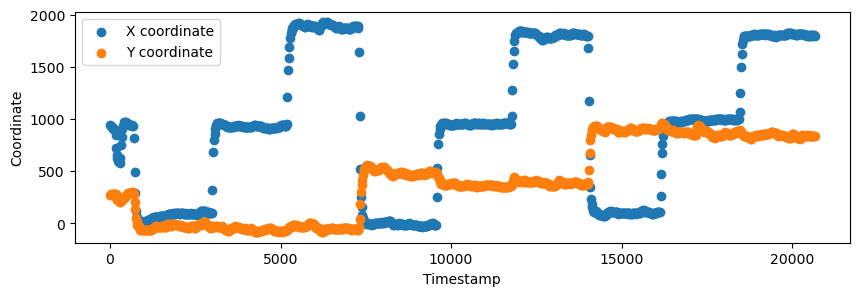

In [19]:
coordinate_data = load_data('vc_modified.csv')
drawing_seperate_scatter(coordinate_data)

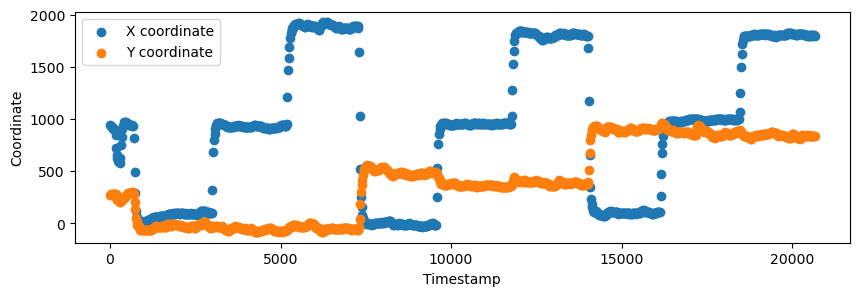

In [20]:
coordinate_data = gap_fill_in(coordinate_data)
drawing_seperate_scatter(coordinate_data)

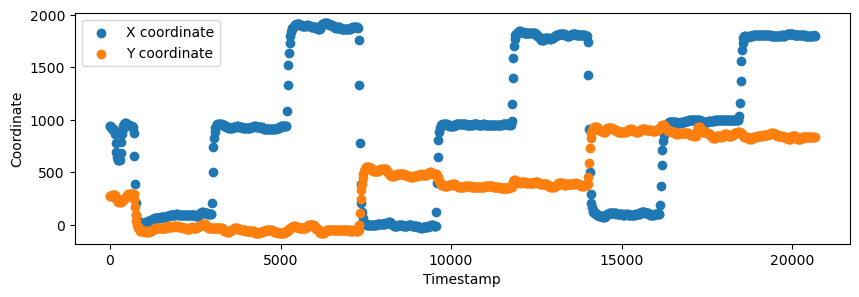

In [21]:
coordinate_date = noise_reducing(coordinate_data, 3)
drawing_seperate_scatter(coordinate_data)

In [22]:
px2deg = pixel_to_degree(60, 70, 1920)

In [23]:
velocity_data = get_angular_velocity(coordinate_data, px2deg)

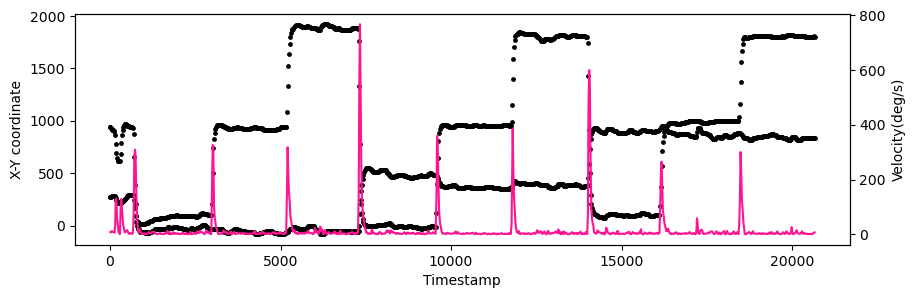

In [24]:
draw_coordinate_velocity(coordinate_data, velocity_data)

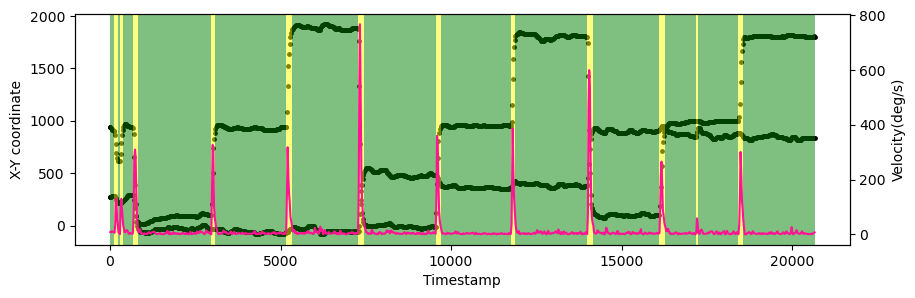

In [25]:
draw_classified_events(coordinate_data, velocity_data)